## 초기 데이터셋 분석
이 노트북에서 writers.stackexchange.com의 실제 질문 데이터셋을 빠르게 살펴 보겠습니다. 이 데이터셋은 원래 아카이브에서 받은 것입니다.

먼저 데이터를 로드합니다. 다른 csv 파일을 로드한다면 ml_editor 파이썬 패키지를 사용해 원시 xml을 전처리해야 합니다.

In [1]:
import json
from tqdm import tqdm
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ElT
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

from pathlib import Path
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

df = pd.read_csv(Path('../data/writers.csv'))

## 데이터 포맷
데이터를 어떻게 포맷팅할지 생각해 보죠. 무엇보다도 모델에 어떤 레이블을 제공할지 결정해야 합니다.

모델은 질문의 품질을 측정합니다. 이를 위해 다음을 사용할 수 있습니다:

질문의 업보트(upvote)의 수
질문의 답변 수, 또는 답변을 받았는지 여부
채택된 답변이 있는지 여부
먼저 데이터셋을 질문과 관련된 답변으로 구성하겠습니다.

누락된 값을 채우고 나중에 사용할 두 개의 특성(text_len와 is_question)을 추가합니다.

In [2]:
# 손쉬운 처리를 위해 타입을 바꿉니다
df["AnswerCount"] = df["AnswerCount"].fillna(-1)
df["AnswerCount"] = df["AnswerCount"].astype(int)
df["PostTypeId"] = df["PostTypeId"].astype(int)
df["Id"] = df["Id"].astype(int)
df.set_index("Id", inplace=True, drop=False)

# 포스트의 길이를 추가합니다.
df["full_text"] = df["Title"].str.cat(df["body_text"], sep=" ", na_rep="")
df["text_len"] = df["full_text"].str.len()

# 질문은 포스트 타입이 1입니다
df["is_question"] = df["PostTypeId"] == 1

## 데이터 품질
다음 질문에 답을 하면서 이 데이터셋의 데이터 품질을 조사해 보죠.

- 얼마나 많은 데이터가 누락되었나요?
- 텍스트의 품질은 무엇인가요?
- 대답이 질문과 일치하나요?

In [3]:
# 열과 Null이 아닌 개수를 출력합니다
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34330 entries, 1 to 42885
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             34330 non-null  int64  
 1   AcceptedAnswerId       4124 non-null   float64
 2   AnswerCount            34330 non-null  int32  
 3   Body                   34256 non-null  object 
 4   ClosedDate             969 non-null    object 
 5   CommentCount           34330 non-null  int64  
 6   CommunityOwnedDate     186 non-null    object 
 7   CreationDate           34330 non-null  object 
 8   FavoriteCount          3307 non-null   float64
 9   Id                     34330 non-null  int32  
 10  LastActivityDate       34330 non-null  object 
 11  LastEditDate           11201 non-null  object 
 12  LastEditorDisplayName  614 non-null    object 
 13  LastEditorUserId       10648 non-null  float64
 14  OwnerDisplayName       1976 non-null   object 
 15  Ow

질문과 답변으로 구성된 34,000 이상의 포스트가 있습니다.

Body 열을 보면 34330 - 34256 = 74 행이 null인 것 같습니다. 이를 삭제해야 하는지 알아보기 위해 이 행을 출력해 보죠.

In [4]:
df[df["Body"].isna()]

,Unnamed: 0,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,...,ParentId,PostTypeId,Score,Tags,Title,ViewCount,body_text,full_text,text_len,is_question
Id,,,,,,,,,,,,,,,,,,,,,
2145,1959,NaN,-1,NaN,NaN,0,NaN,2011-03-22T19:49:56.600,NaN,2145,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2147,1961,NaN,-1,NaN,NaN,0,NaN,2011-03-22T19:51:05.897,NaN,2147,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2215,2029,NaN,-1,NaN,NaN,0,NaN,2011-03-24T19:35:10.353,NaN,2215,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2218,2032,NaN,-1,NaN,NaN,0,NaN,2011-03-24T19:41:38.677,NaN,2218,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
2225,2039,NaN,-1,NaN,NaN,0,NaN,2011-03-24T19:58:59.833,NaN,2225,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42223,33706,NaN,-1,NaN,NaN,0,NaN,2019-02-14T09:42:01.813,NaN,42223,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
42549,34006,NaN,-1,NaN,NaN,0,NaN,2019-02-24T05:18:39.920,NaN,42549,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False
42551,34008,NaN,-1,NaN,NaN,0,NaN,2019-02-24T05:26:20.740,NaN,42551,...,NaN,5,0,NaN,NaN,NaN,NaN,,1,False


null인 body는 모두 PostTypeId가 4 또는 5입니다.

아카이브와 함께 제공된 readme 파일에는 PostTypeId 1(질문)과 2(답변)만 언급되어 있습니다. 질문과 답변만 관심 대상이므로 PostTypeId가 1 또는 2가 아닌 모든 행을 삭제합니다.

In [5]:
df = df[df["PostTypeId"].isin([1,2])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33650 entries, 1 to 42885
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             33650 non-null  int64  
 1   AcceptedAnswerId       4124 non-null   float64
 2   AnswerCount            33650 non-null  int32  
 3   Body                   33650 non-null  object 
 4   ClosedDate             969 non-null    object 
 5   CommentCount           33650 non-null  int64  
 6   CommunityOwnedDate     186 non-null    object 
 7   CreationDate           33650 non-null  object 
 8   FavoriteCount          3307 non-null   float64
 9   Id                     33650 non-null  int32  
 10  LastActivityDate       33650 non-null  object 
 11  LastEditDate           10521 non-null  object 
 12  LastEditorDisplayName  606 non-null    object 
 13  LastEditorUserId       9975 non-null   float64
 14  OwnerDisplayName       1971 non-null   object 
 15  Ow

이제 몇 개의 질문과 답변을 출력하고 두 내용이 일치하는지, 읽을 수 있는지 확인해 보겠습니다.

In [6]:
questions_with_accepted_answers = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]
q_and_a = questions_with_accepted_answers.join(df[["body_text"]], on="AcceptedAnswerId", how="left", rsuffix="_answer")

# 모든 데이터를 출력하기 위해 이 옵션을 설정합니다
pd.options.display.max_colwidth = 500
q_and_a[["body_text", "body_text_answer"]][:3]

,body_text,body_text_answer
Id,,
1,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n","When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when re..."
2,"What kind of story is better suited for each point of view? Are there advantages or disadvantages inherent to them?\nFor example, writing in the first person you are always following a character, while in the third person you can ""jump"" between story lines.\n","With a story in first person, you are intending the reader to become much more attached to the main character. Since the reader sees what that character sees and feels what that character feels, the reader will have an emotional investment in that character. Third person does not have this close tie; a reader can become emotionally invested but it will not be as strong as it will be in first person.\nContrarily, you cannot have multiple point characters when you use first person without ex..."
3,"I finished my novel, and everyone I've talked to says I need an agent. How do I find one?\n","Try and find a list of agents who write in your genre. Check out their websites!\nFind out if they are accepting new clients. If they aren't, then check out another agent. But if they are, try sending them a few chapters from your story, a brief, and a short cover letter asking them to represent you.\nIn the cover letter mention your previous publication credits. If sent via post, then I suggest you give them a means of reply, whether it be an email or a stamped, addressed envelope.\nAgents ..."


네 좋습니다. 질문과 답변이 잘 맞는 것 같군요. 개행문자("\n")를 제외하면 이 텍스트는 논리적이고 사람이 읽을 수 있습니다.

질문이 대답을 받았는지 정보를 각 행에 추가하겠습니다.

In [7]:
df = df.join(df[["Id", "Title", "body_text", "text_len", "Score", "AcceptedAnswerId"]], on="ParentId", how="left", rsuffix='_question')


이렇게 하면 주어진 질문에 대한 모든 답변을 확인할 수 있습니다.

In [8]:
df[df["Id_question"] ==1].head()

,Unnamed: 0,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,...,body_text,full_text,text_len,is_question,Id_question,Title_question,body_text_question,text_len_question,Score_question,AcceptedAnswerId_question
Id,,,,,,,,,,,,,,,,,,,,,
8,5,NaN,-1,"<p>BeginningWriters.com has some good articles for beginning writers.</p>\n\n<p><a href=""http://beginningwriters.com/"">http://beginningwriters.com/</a></p>\n",NaN,0,NaN,2010-11-18T20:45:45.533,NaN,8,...,BeginningWriters.com has some good articles for beginning writers.\nhttp://beginningwriters.com/\n,BeginningWriters.com has some good articles for beginning writers.\nhttp://beginningwriters.com/\n,97,False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",352.0,32.0,15.0
15,10,NaN,-1,"<p>When I'm thinking about where I learned most how to write, I think that <em>reading</em> was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I ...",NaN,3,NaN,2010-11-18T20:50:16.683,NaN,15,...,"When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when re...","When I'm thinking about where I learned most how to write, I think that reading was the most important guide to me. This may sound silly, but by reading good written newspaper articles (facts, opinions, scientific articles and most of all, criticisms of films and music), I learned how others did the job, what works and what doesn't. In my own writing, I try to mimic other people's styles that I liked. Moreover, I learn new things by reading, giving me a broader background that I need when r...",962,False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",352.0,32.0,15.0
79,65,NaN,-1,"<p>I particularly like <a href=""http://www.advancedfictionwriting.com/art/snowflake.php"" rel=""nofollow"" rel=""nofollow"">The Snowflake Method</a> and most of what Randy writes, including his book.</p>\n",NaN,0,NaN,2010-11-18T23:19:33.157,NaN,79,...,"I particularly like The Snowflake Method and most of what Randy writes, including his book.\n","I particularly like The Snowflake Method and most of what Randy writes, including his book.\n",93,False,1.0,What are some online guides for starting writers?,"I've always wanted to start writing (in a totally amateur way), but whenever I want to start something I instantly get blocked having a lot of questions and doubts.\nAre there some resources on how to start becoming a writer?\nI'm thinking something with tips and easy exercises to get the ball rolling.\n",352.0,32.0,15.0
123,106,NaN,-1,"<p>Reading a lot and loving to read are most important of course, but have you tried writing

## 데이터 품질과 분포
이제 질문과 답변을 연결했고 데이터 품질을 검증했으므로 요약 통계를 만들어 보죠.

- 데이터셋에 얼마나 많은 질문이 있나요?
- 얼마나 많은 질문이 답변을 받았나요?
- 질문은 얼마나 긴가요?

In [9]:
has_accepted_answer = df[df["is_question"] & ~(df["AcceptedAnswerId"].isna())]
received_answers = df[df["is_question"] & (df["AnswerCount"]!=0)]
no_answers = df[df["is_question"] & (df["AcceptedAnswerId"].isna()) & (df["AnswerCount"]==0)]

print("총 질문: %s개, 1개 이상의 답변을 가진 질문: %s개, 답변이 채택된 질문: %s개" % (
    len(df[df["is_question"]]),
    len(received_answers),
    len(has_accepted_answer)))

총 질문: 7971개, 1개 이상의 답변을 가진 질문: 7827개, 답변이 채택된 질문: 4124개


대부분의 질문은 답변을 받았습니다. 이 답변 중 절반만 채택되었습니다. 질문에 채택된 답변이 있는지 여부는 좋은 레이블이 될 수 있습니다.

또 다른 가능성있는 레이블은 Score 열에 있는 질문이 받은 업보트 수입니다. 모델을 얼마나 상세화할지에 따라 이 레이블을 이진 특성(예를 들어, 이 점수가 중앙값보다 큰지 작은지) 또는 연속적으로 다룰 수 있기 때문에 유용합니다. 이 점수의 분포를 다음에 그려 보겠습니다.

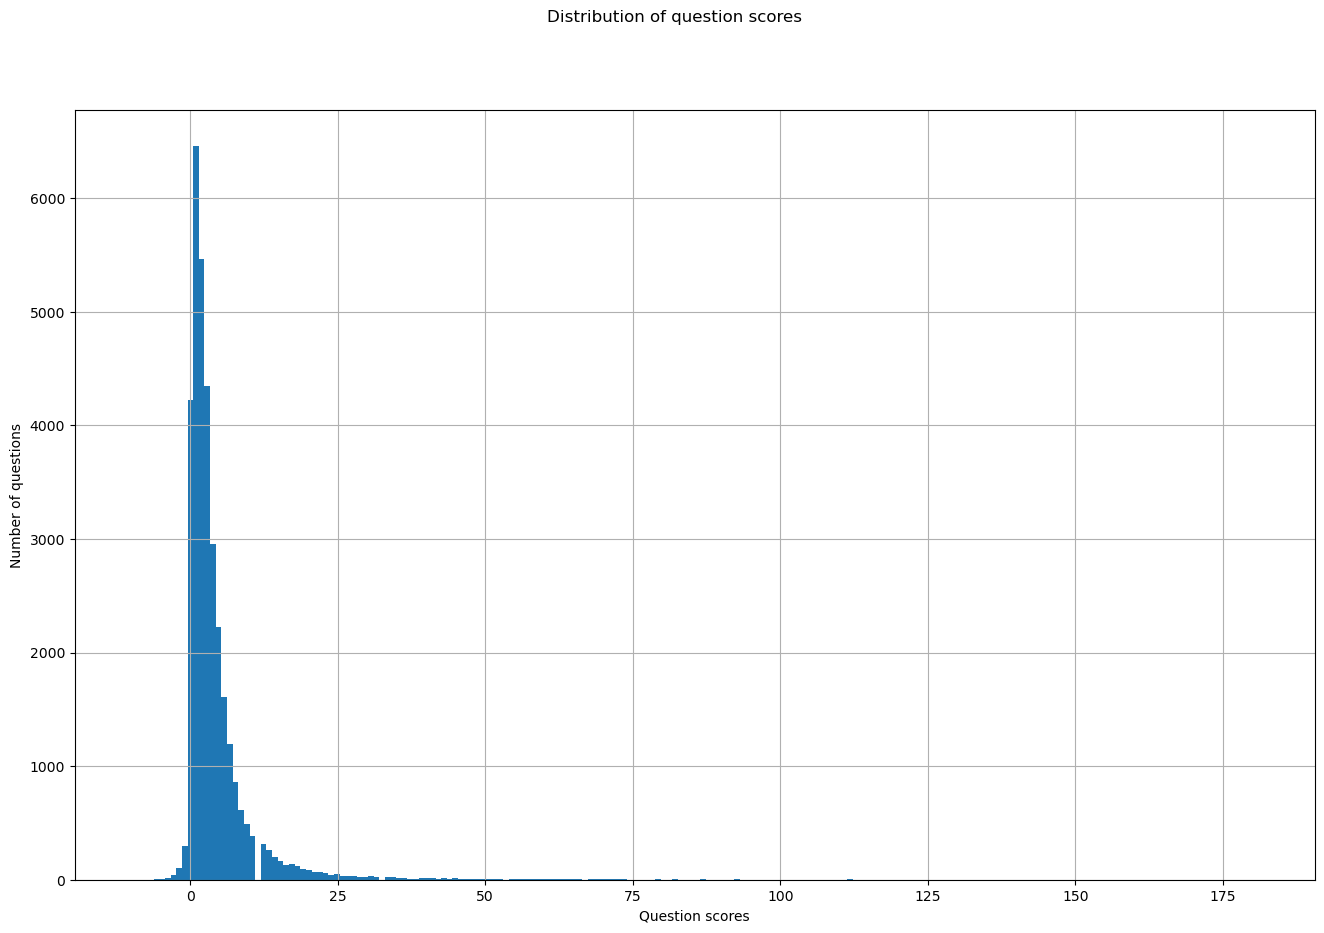

In [10]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("Distribution of question scores")
plt.xlabel("Question scores")
plt.ylabel("Number of questions")
df["Score"].hist(bins=200);

질문 길이 같은 예측에 좋은 특성을 살펴 보는 식으로 질문에 조금 더 자세히 분석해 보겠습니다. 데이터셋에 있는 질문의 길이는 얼마나 될까요?

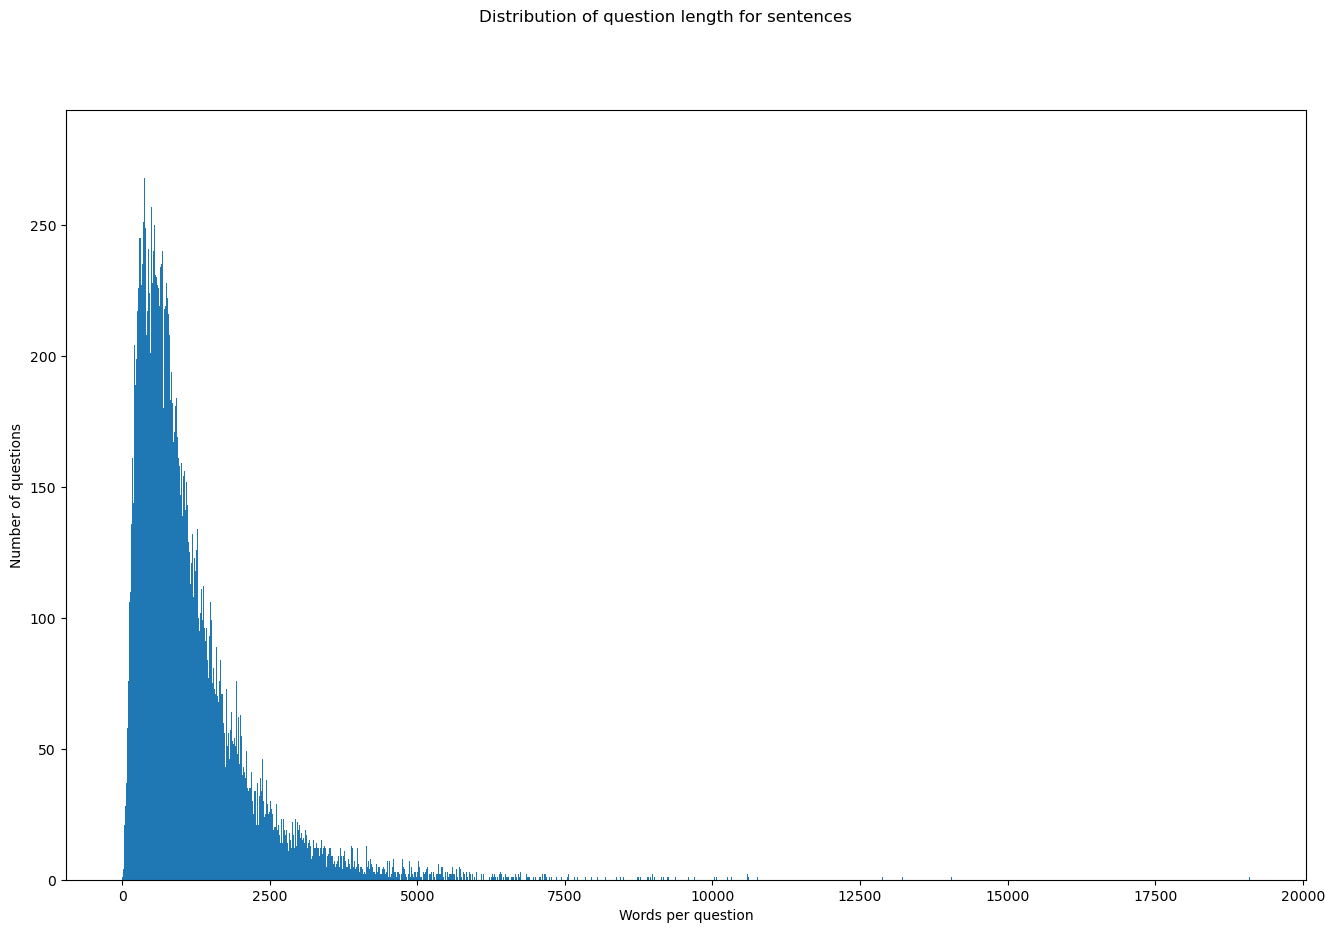

In [11]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("Distribution of question length for sentences")
plt.xlabel("Words per question")
plt.ylabel("Number of questions")
q_len = plt.hist(df["text_len"],  bins=2000,log=False)

몇 개의 이상치만이 이 천개 이상의 단어를 포함하고 있습니다. 그래프에서 짧은 질문을 크게 확대해 보겠습니다.

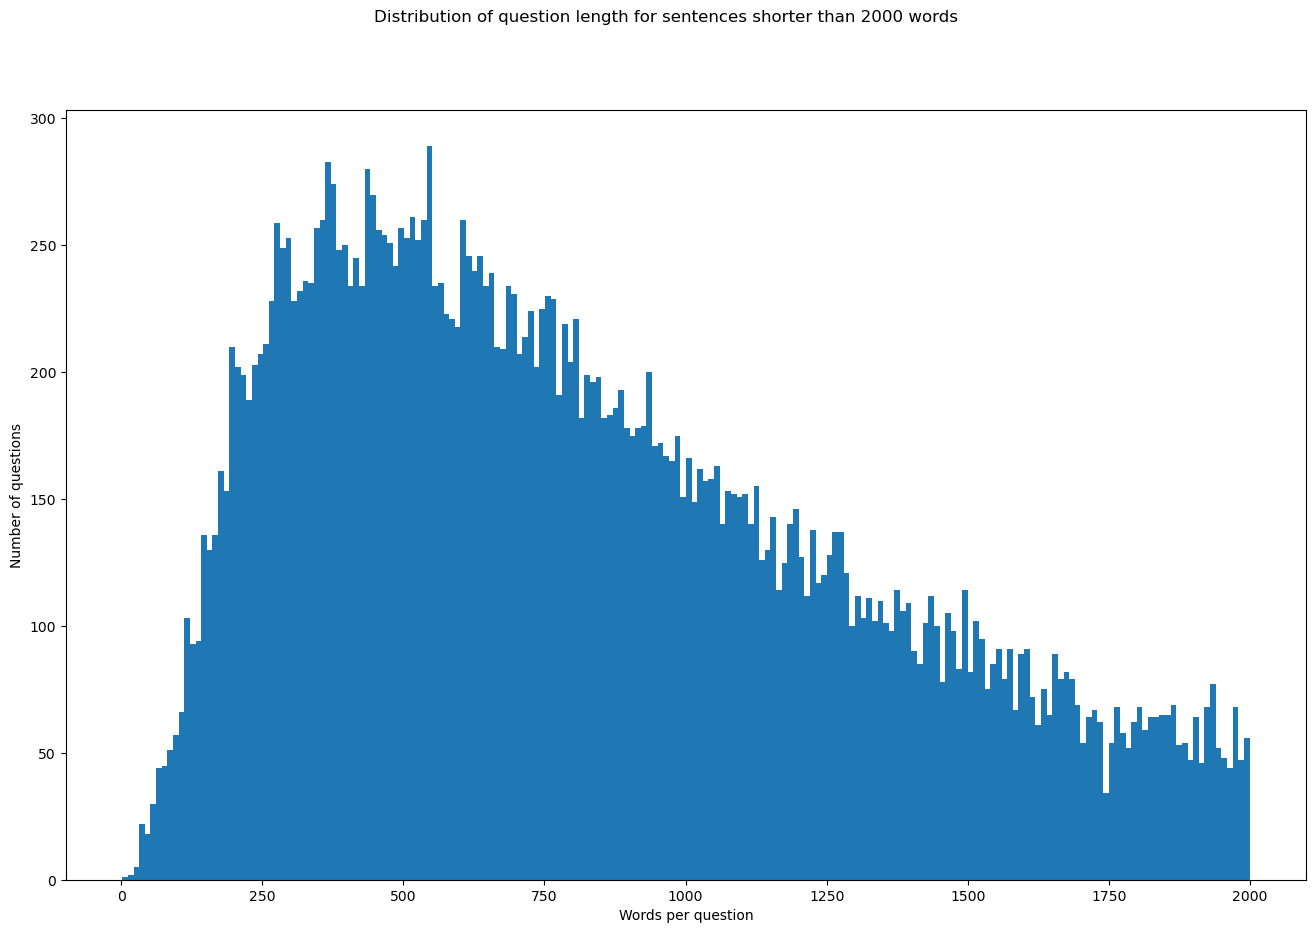

In [12]:
fig = plt.figure(figsize=(16,10))
fig.suptitle(
    "Distribution of question length for sentences shorter than 2000 words")
plt.xlabel("Words per question")
plt.ylabel("Number of questions")
q_len_trunc = plt.hist(df[df["text_len"]<2000]["text_len"], bins=200, log=False)

질문의 길이로 많은 업보트를 얻는 것을 예측할 수 있을까요?

이 질문에 대답하기 위해 높은 점수의 질문과 낮은 점수의 질문에 대한 두 분포를 겹쳐서 그려 볼 수 있습니다.

Text(0, 0.5, 'Percentage of sentences')

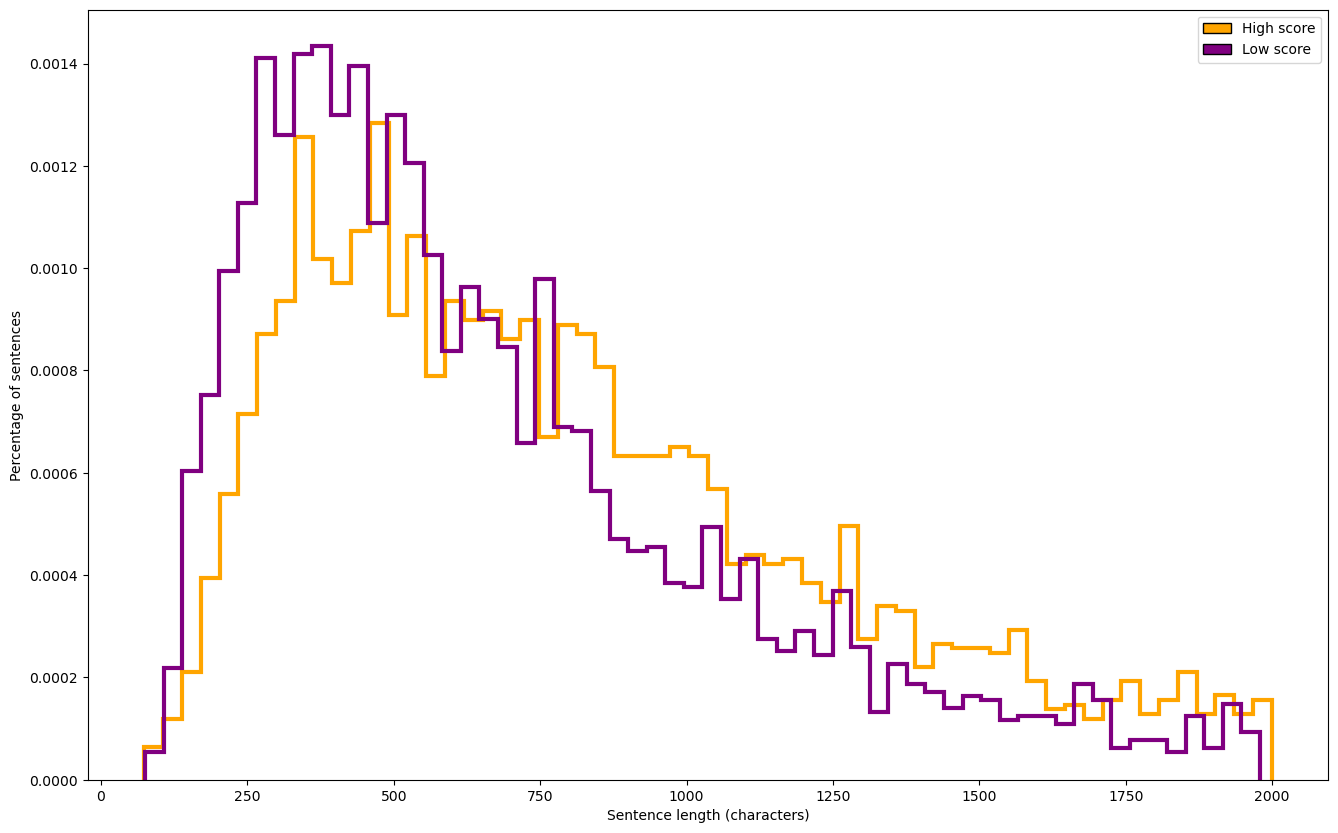

In [13]:
high_score = df["Score"] > df["Score"].median()
# 아주 긴 질문을 제외힙니다
normal_length = df["text_len"] < 2000

ax = df[df["is_question"] & high_score & normal_length]["text_len"].hist(
    bins=60,
    density=True,
    histtype="step",
    color="orange",
    linewidth=3,
    grid=False,
    figsize=(16, 10),
)

df[df["is_question"] & ~high_score & normal_length]["text_len"].hist(
    bins=60,
    density=True,
    histtype="step",
    color="purple",
    linewidth=3,
    grid=False,
)

handles = [
    Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ["orange", "purple"]
]
labels = ["High score", "Low score"]
plt.legend(handles, labels)
ax.set_xlabel("Sentence length (characters)")
ax.set_ylabel("Percentage of sentences")

높은 점수의 질문은 평균적으로 길이가 더 깁니다. 즉 질문의 길이는 모델에 적용할 수 있는 후보 특성입니다.

품질 측정 방법으로 질문이 받은 답변 수의 분포를 자세히 살펴 보겠습니다.

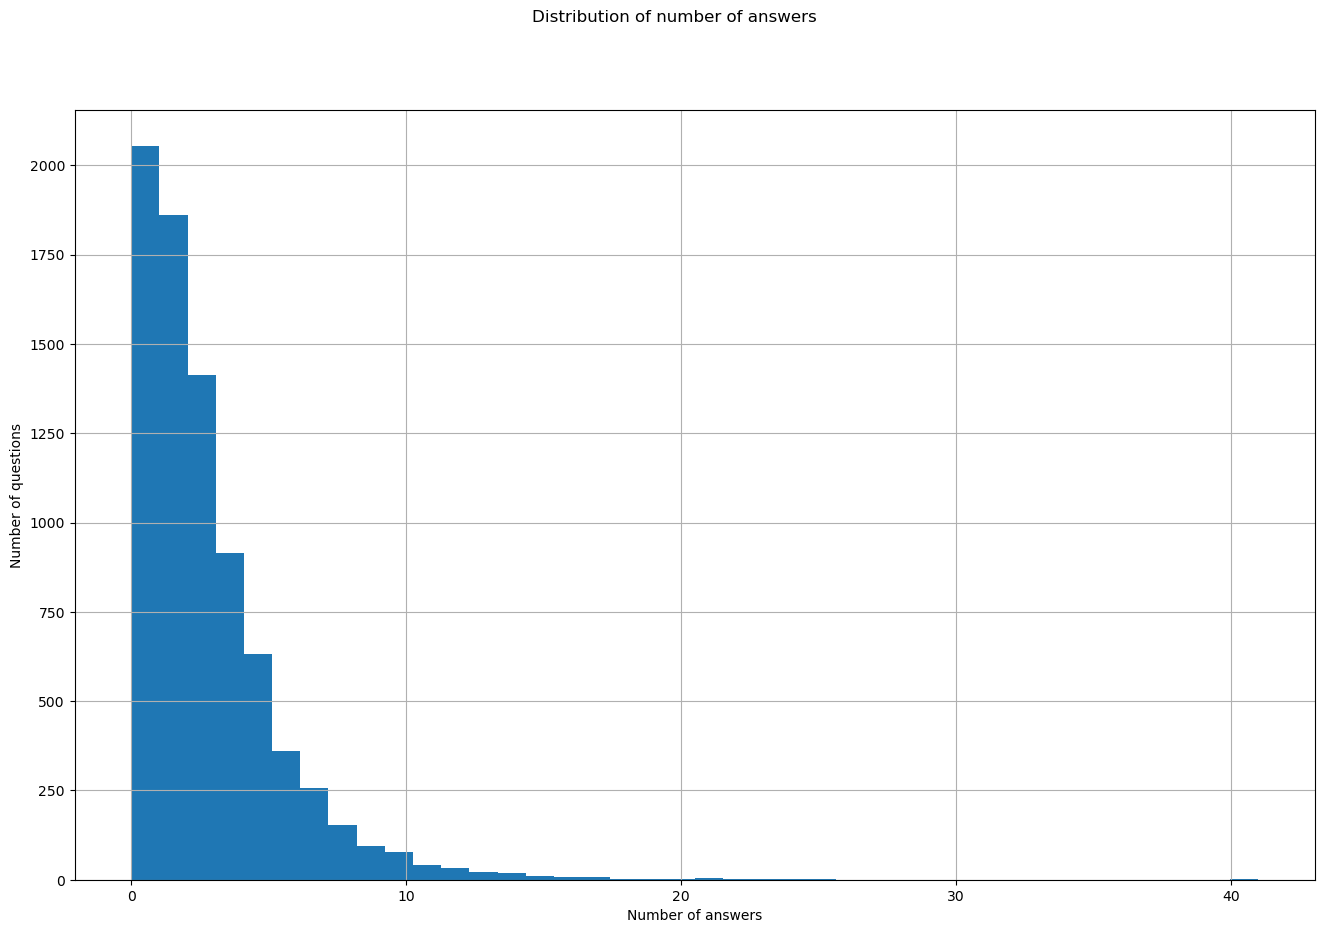

In [14]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("Distribution of number of answers")
plt.xlabel("Number of answers")
plt.ylabel("Number of questions")
hist = df[df["is_question"]]["AnswerCount"].hist(bins=40)

높은 점수의 질문이 더 많은 답변을 받았는지 확인해 보죠.

먼저 한 변수에 대한 함수로 다른 한 변수를 그리면 트렌드를 파악할 수 있습니다.

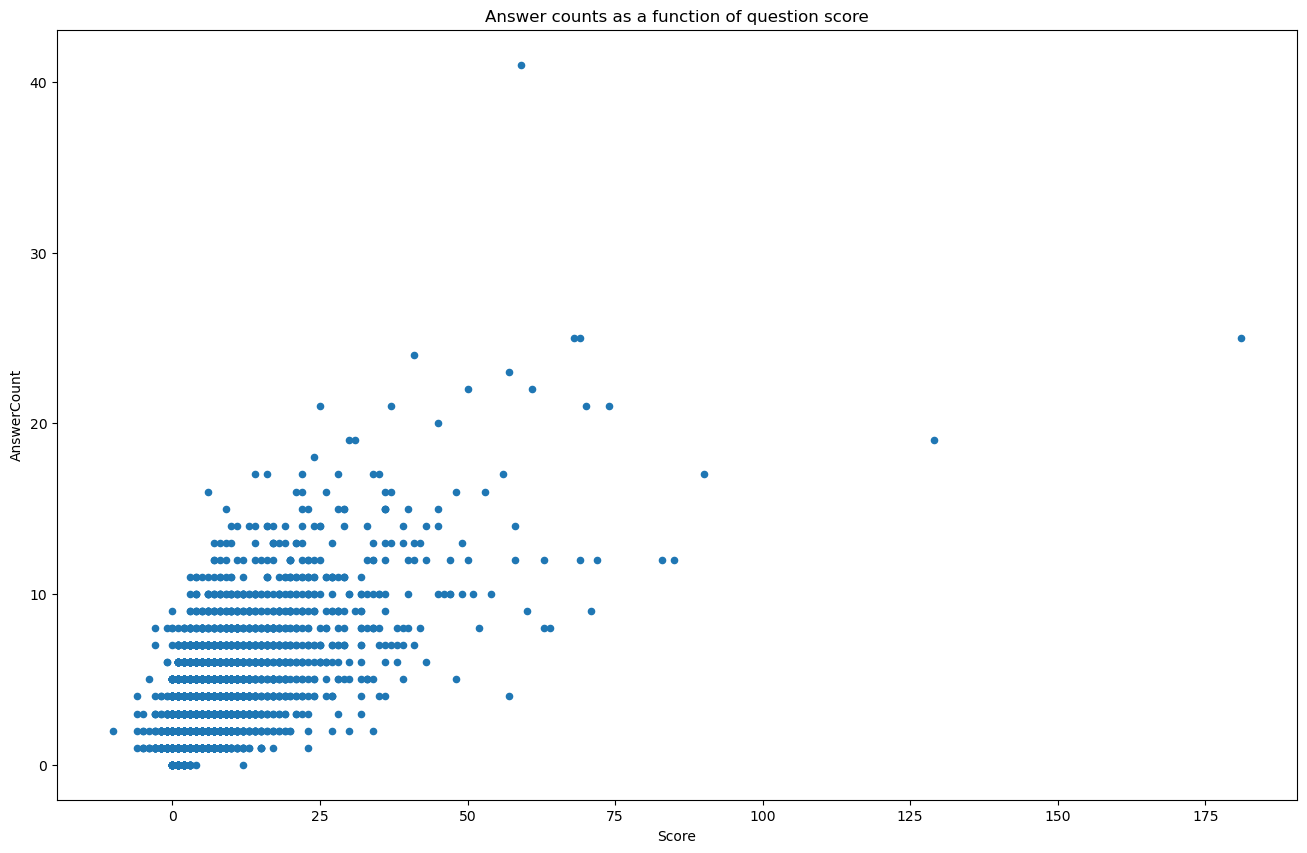

In [15]:
scatter = df[df["is_question"]][["Score", "AnswerCount"]].plot(x="Score", y="AnswerCount", 
                                                               kind="scatter",
                                                              figsize=(16, 10))
ax.set_xlabel("Score")
ax.set_ylabel("Num answers")
scatter.set_title("Answer counts as a function of question score");

점수와 답변의 개수는 상관관계가 있는 것 같군요. 점수를 is_score_above_median를 사용해 이진 레이블로 만드는 것에 대해 언급했습니다. 이 레이블이 답변의 개수와 상관관계가 있는지 알아 보겠습니다. 이를 위해 카테고리(중앙값보다 큰 점수와 작은 점수)마다 질문이 받은 답변의 개수를 히스토그램으로 그립니다.



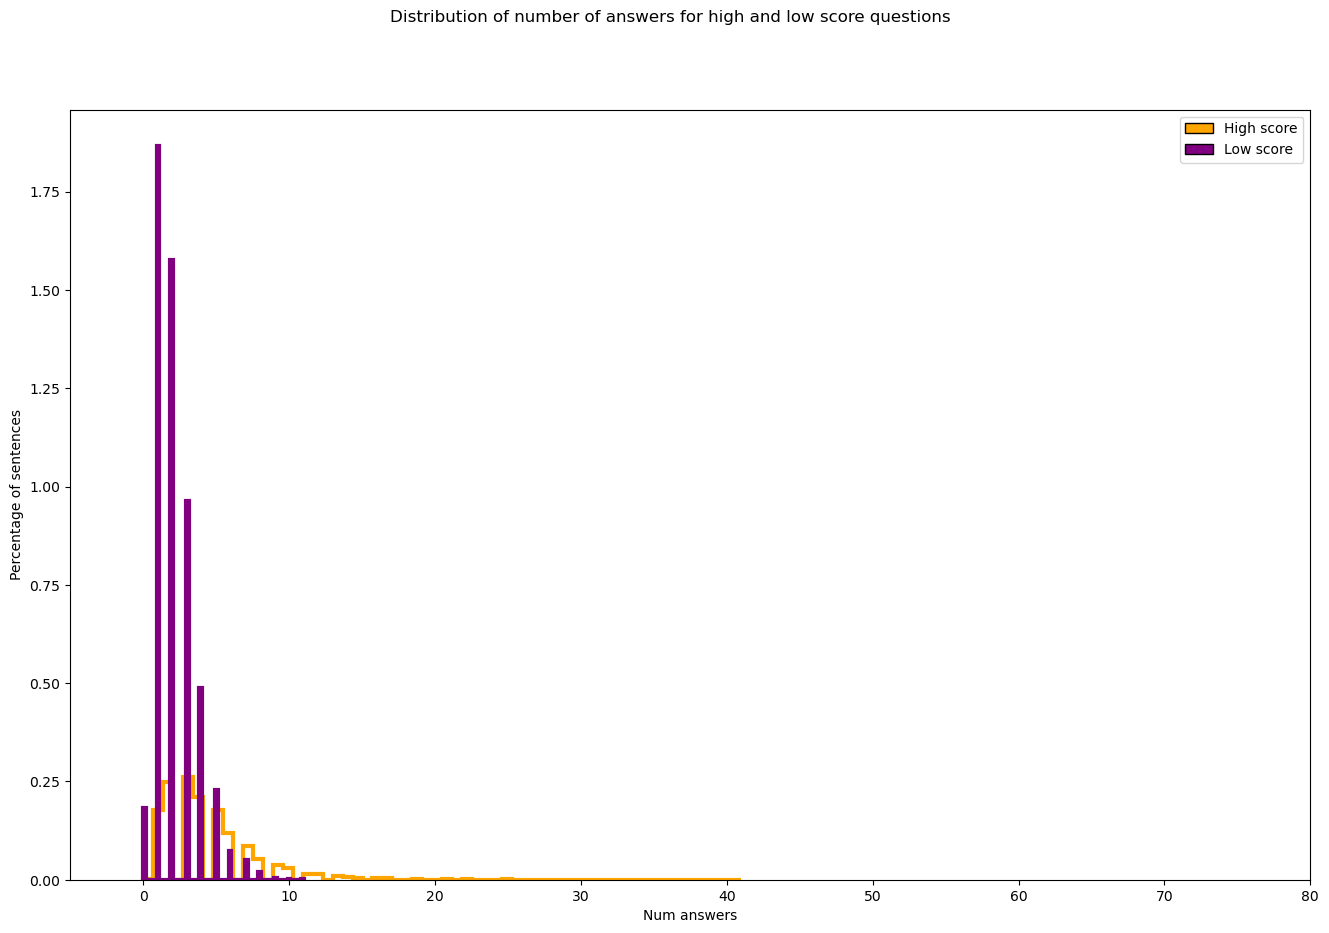

In [16]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("Distribution of number of answers for high and low score questions")
plt.xlim(-5,80)

ax = df[df["is_question"] &
        (df["Score"] > df["Score"].median())]["AnswerCount"].hist(bins=60,
                                                          density=True,
                                                          histtype="step",
                                                          color="orange",
                                                          linewidth=3,
                                                          grid=False,
                                                          figsize=(16, 10))

df[df["is_question"] &
   ~(df["Score"] > df["Score"].median())]["AnswerCount"].hist(bins=60,
                                                     density=True,
                                                     histtype="step",
                                                     color="purple",
                                                     linewidth=3,
                                                     grid=False)

handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in
           ["orange", "purple"]]
labels = ["High score", "Low score"]
plt.legend(handles, labels)
ax.set_xlabel("Num answers")
ax.set_ylabel("Percentage of sentences");

높은 점수를 얻은 질문이 더 많은 답변을 받은 것 같습니다. 질문의 점수는 상세 수준으로 다룰 수 있기 때문에 좋은 레이블로 보입니다. 하지만 답변의 개수도 좋은 선택입니다.

답변의 개수가 좋은 레이블이지만 특성으로 사용할 수는 없습니다. 그래프에서 보듯이 점수와 상관관계가 있음에도 사용자가 질문을 입력하는 추론시에 이를 얻을 수 없기 때문입니다.

모델이 이 정보 없이 동작해야 하므로 훈련하는 동안 이를 완전히 무시하거나 훈련에 사용하고 제품 환경에서는 특성 값을 상수로 설정할 수 있습니다. 첫 번째 방법이 간단합니다. 하지만 두 번째 방법은 감지하려는 다른 스타일의 영향에서 답변 개수 특성의 영향을 분리하는데 도움이 됩니다. 두 방법에 대해 실험을 독자에게 남겨 놓겠습니다.

데이터 탐색을 마친 후 데이터 분할 방법을 알아 보겠습니다.